In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sde.sde_learning_network import \
    (
        SDEIdentification,
        ModelBuilder,
        SDEApproximationNetwork,
    )

from sde.experiment_reports import \
(
    sample_data,
    plot_results_functions,
    generate_results,
    plot_results_1d
)

%load_ext autoreload
%autoreload 2

D:\SOFTWARE\Anaconda\envs\tf24_py38\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:
import os
print(os.getcwd())
print(os.listdir('.')) # 查看当前目录下的文件和文件夹
print(os.listdir('sde')) # 尝试查看 sde 文件夹的内容，前提是它在当前目录下

D:\SOFTWARE\PyCharmprojects\NB\teacher_\20250429\sde-identification-master\sde-identification-master
['.gitignore', '.idea', 'example1 - 1d sde - VAE.ipynb', 'example1 - 1d sde.ipynb', 'example2 - 2d sde.ipynb', 'example3 - 1d sde-cubic - with parameters.ipynb', 'example3 - 1d sde-cubic-with-milstein.ipynb', 'example3 - 1d sde-cubic.ipynb', 'example3 - 2d sde-cubic - with parameters 2d.ipynb', 'example3 - nd sde-cubic.ipynb', 'example4 - 3d sde-nondiagonal.ipynb', 'example4 - 3d sde-spd.ipynb', 'example5 - generative.ipynb', 'example5 - milstein vs euler learning02.ipynb', 'example6 - SIRGillespie1024.ipynb', 'example7 - Wave SPDE.ipynb', 'example8 - nonGaussian.ipynb', 'figures', 'gillespie', 'kMClattice', 'Paper Supplemental Material', 'README.md', 'requirements.txt', 'sde', 'SDE-net-comparison.ipynb', 'test - dmap on lattices.ipynb', 'test - euler vs milstein convergence.ipynb', 'test - milstein method.ipynb', 'test - probability gillespie.ipynb', 'test - python SIR gillespie-c.ipyn

In [10]:
# notebook parameters
random_seed = 1
step_size = 1e-1  # 5e-2 # step size
n_pts = 10000        # number of points

n_layers = 1
n_dim_per_layer = 25

n_dimensions = 1

ACTIVATIONS = tf.nn.elu #激活函数
VALIDATION_SPLIT = 0.1 #验证比例
BATCH_SIZE = 512
N_EPOCHS = 25

# only diagonal diffusivity matrix (does not matter since we are in 1D)
diffusivity_type = "diagonal"

tf.random.set_seed(random_seed)

In [11]:
# EXAMPLE 1
def true_drift(x, param=None):
    return -0.5*x


def true_diffusivity(x, param=None):
    return 0*(x*x)*0.01+np.sqrt(0.01)


def true_drift_diffusivity(x, param=None):
    return true_drift(x), true_diffusivity(x)


rng = np.random.default_rng(random_seed)

x_data, y_data = sample_data(true_drift_diffusivity,
                             step_size=step_size, n_dimensions=n_dimensions,
                             low=-1, high=1, n_pts=n_pts,
                             rng=rng)
x_data_test, y_data_test = sample_data(true_drift_diffusivity,
                                       step_size=step_size,
                                       n_dimensions=n_dimensions,
                                       low=-1, high=1,
                                       n_pts=n_pts//10, rng=rng)
print('data shape', x_data.shape)

step_sizes = np.zeros((x_data.shape[0],)) + step_size

data shape (10000, 1)


In [6]:
# define the neural network model we will use for identification
encoder = ModelBuilder.define_gaussian_process(
                                        n_input_dimensions=n_dimensions,
                                        n_output_dimensions=n_dimensions,
                                        n_layers=n_layers,
                                        n_dim_per_layer=n_dim_per_layer,
                                        name="GP",
                                        activation=ACTIVATIONS,
                                        diffusivity_type=diffusivity_type)
encoder.summary()

model = SDEApproximationNetwork(sde_model=encoder, method="euler") #包装网络成为可训练模型
model.compile(optimizer=tf.keras.optimizers.Adamax())

sde_i = SDEIdentification(model=model) #训练器封装类

Model: "GP_gaussian_process"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
GP_inputs (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
GP_mean_hidden_0 (Dense)        (None, 25)           50          GP_inputs[0][0]                  
__________________________________________________________________________________________________
GP_std_hidden_0 (Dense)         (None, 25)           50          GP_inputs[0][0]                  
__________________________________________________________________________________________________
GP_output_mean (Dense)          (None, 1)            26          GP_mean_hidden_0[0][0]           
________________________________________________________________________________

training for 25 epochs with 9000 data points, validating with 1000
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it with `scale_diag` directly instead.
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
The average loss for epoch 24 is -0.4612190393 

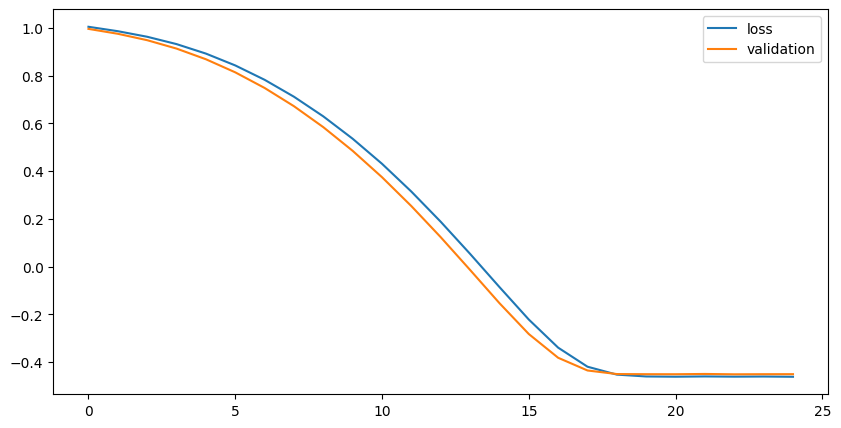

In [7]:
hist = sde_i.train_model(x_data, y_data, step_size=step_sizes,
                         validation_split=VALIDATION_SPLIT, n_epochs=N_EPOCHS, batch_size = BATCH_SIZE)

fig, hist_axes = plt.subplots(1, 1, figsize=(10, 5))
hist_axes.clear()
hist_axes.plot(hist.history["loss"], label='loss')
hist_axes.plot(hist.history["val_loss"], label='validation')
hist_axes.legend()

(0.0, 0.15)

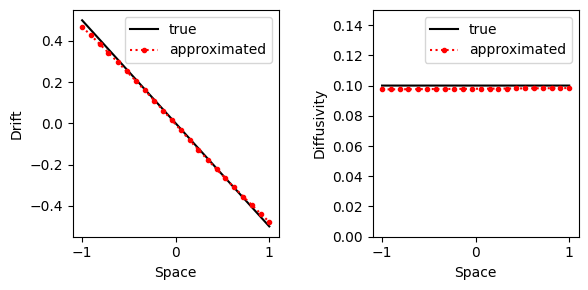

In [8]:
rng = np.random.default_rng(random_seed)

fig, ax = plot_results_functions(sde_i.drift_diffusivity, true_drift_diffusivity,
                            x_data, y_data, rng,
                            data_transform_network=None,
                            data_transform_true=None)
ax[1].set_ylim([0, .15])

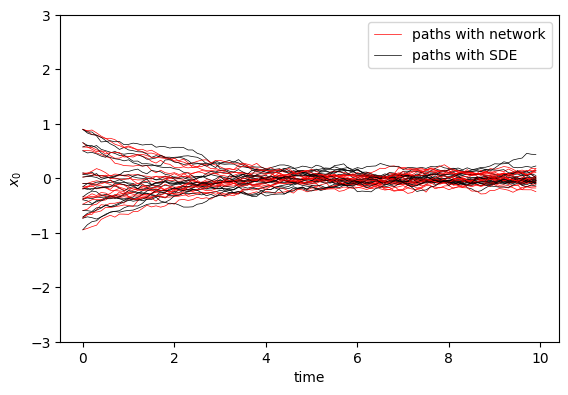

In [9]:
T_steps = 100
N_iterates = 20

rng = np.random.default_rng(random_seed)

time_steps, paths_network = \
    generate_results(sde_i.drift_diffusivity,
                     step_size, x_data, rng,
                     T_steps=T_steps, N_iterates=N_iterates);
time_steps, paths_true = \
    generate_results(true_drift_diffusivity,
                     step_size, x_data, rng,
                     T_steps=T_steps, N_iterates=N_iterates);

plot_results_1d(time_steps, paths_network, paths_true, plot_dim=0, linewidth=.5);
plt.gca().set_ylim([-3,3])
plt.gca().set_ylabel(r"$x_0$");